# Figure processing pipeline population model

In [ ]:
%%javascript
Jupyter.notebook.session.restart({kernel_name: 'python2'})

After running the cell above you can go ahead and run the ones below, even if the cell above appears 'busy'

In [8]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from brian2 import *
from scipy.signal import fftconvolve

## Setting up the BIPD distribution

In [2]:
__all__ = ['generate_random_mcalpine_et_al_2001_bds']

def fixup(s):
    s = s.replace(',', '.')
    s = s.split('\n')
    s = [map(float, w.split('    ')) for w in s if w]
    f, bitd = zip(*s)
    f = array(f) * kHz
    bitd = array(bitd) * usecond
    return f, bitd

fig_2a_means = '''
0,09455    707,10712
0,16542    520,84442
0,23318    361,37778
0,29635    277,76535
0,35333    232,09654
0,41458    182,66420
0,46000    163,59335
0,51884    205,06943
0,57556    148,14299
0,61844    113,97392
0,68096    147,91190
0,75553    117,48437
0,80553    121,18188
0,99987    109,52809
'''

fig_2a_means_plus_stds = '''
0,09879    1125,42432
0,19757    819,93372
0,30073    604,84766
0,39557    412,23495
0,49462    412,60233
0,59540    333,41052
0,68949    242,79839
0,78939    307,37531
0,89622    250,80063
0,97863    201,73302
1,09955    209,49567
1,23526    228,61478
1,34885    179,54718
1,75320    191,33490
'''
_, mean_bitd = fixup(fig_2a_means)
f, bitd_mean_plus_std = fixup(fig_2a_means_plus_stds)
std_bitd = bitd_mean_plus_std - mean_bitd

def generate_random_mcalpine_et_al_2001_bds(cf, N, std_factor=1.0):
    fmid = 0.5 * (f[1:] + f[:-1])
    I = digitize(cf, fmid)
    mu = mean_bitd[I] * 2 * cf[0] * 180.0
    sigma = std_bitd[I] * std_factor * 2 * cf[0] * 180.0
    x_axis = np.arange(-180, 180, 360.0 / N)

    ##Creating the 2-sided BIPD distribution
    dist_bipd = exp(-(mu - x_axis) ** 2 / (2 * sigma ** 2)) + exp(-(-mu - x_axis) ** 2 / (2 * sigma ** 2))
    dist_bipd = dist_bipd / max(dist_bipd)
    dist_bipd_recentered = np.concatenate((dist_bipd[int(N / 2):int(N)], dist_bipd[0:int(N / 2)]))

    return dist_bipd_recentered

## Creating inhibition kernel

In [11]:
def patt_act_gen(params,f_m,ipd,dyn=False):
    fm=f_m*Hz
    fc=params['f_c']*Hz
    taub=params['tau_b']*ms
    fm_max=64*Hz
    
    # Number of envelope cycles
    n=int(1 + np.ceil(3*taub*fm_max))
    if n % 2 == 0:
        n += 1
    # Time discretization, delta_t=n_t/fm
    t = linspace(0,1,n*params['n_t'])*(1.0*n/fm)
    
    # BIPD discretization, delta_bipd=2*pi/n_bipd
    bipd = linspace(0,2*n*pi,n*params['n_bipd'],endpoint=False)%(2*pi)
    
    # Creating time/bipd 2Dspace
    T, BIPD = meshgrid(t, bipd)
    
    # Stimulus  Envelope 
    A = 0.5*clip(1-params['m']*cos(2*pi*fm*T),0,Inf)
    
    # Converting starting phase to radian.
    dphi_phase_rad=params['dphi_phase']*pi/180.0
    
    # Dynamic or static ipd
    if dyn:
        PHI=(2*pi*fm*T+dphi_phase_rad)%(2*pi)
    else:
        PHI=ipd%(2 * pi)
    # Tuning curve
    TC=(cos((BIPD - PHI) / 2))** params['k']
    
    # modeling the neural activity
    patt_act = TC * A
    
    # Defining borders of the region of interest after convolution
    bipd_inf = int((params['n_bipd'] * n) * ((n - 1) / (2.0 * n)))
    bipd_sup = int((params['n_bipd'] * n) * ((n + 1) / (2.0 * n)))
    t_inf = int(params['n_t'] * n * (1 - 1.0 / n))
    t_sup = int(params['n_t'] * n)
    
    # Producing BIPD distribution based on carrier frequency
    if params['mcAlp_bipd']:
        h_bipd = np.tile(generate_random_mcalpine_et_al_2001_bds([fc], params['n_bipd'], std_factor=1.0), n)
        patt_act_weighted = patt_act*h_bipd[..., np.newaxis]
    else:
        patt_act_weighted = patt_act

    # Setting up the number of neurons participating to the inhibition
    bipd_window = int(params['sigma_k']*params['n_bipd'])
    # delta_t
    pix_t = 1.0/(params['n_t'] * fm)
    #delta_bipd
    pix_bipd = 2*pi/params['n_bipd']
    # Setting up the kernel
    # t-axis
    ksize_t = int(3.*taub/pix_t)
    dt = arange(-ksize_t, ksize_t + 1) * pix_t
    # BIPD axis
    dbipd = arange(-floor(bipd_window/2), floor(bipd_window/2) + 1) * pix_bipd
    DT, DBIPD = meshgrid(dt, dbipd)
    
    kernel0 = where(DT >= 0, 0, exp(DT/taub))

    kernel0[dbipd.shape[0] / 2, :] = 0
    kernel0[:, kernel0.shape[1] / 2] = 0
    
    # Normalization of the kernel
    kernel = kernel0 * pix_t / (1.0 * taub)
   
    # 2D convolution over multiple cycles to remove any border effects
    inh_layer = fftconvolve(patt_act_weighted, kernel[::-1, ::-1], mode='same')
    
    # Crop resulting images to zone of interest, ie the last 2 envelope cycles
    patt_act_weighted_inh= clip(patt_act_weighted - params['gamma'] * inh_layer, 0, inf)
    patt_act = np.concatenate((patt_act[bipd_inf:bipd_sup, t_inf:t_sup], 
                               patt_act[bipd_inf:bipd_sup, t_inf:t_sup]), 1)
    patt_act_weighted = np.concatenate((patt_act_weighted[bipd_inf:bipd_sup, t_inf:t_sup],
                                        patt_act_weighted[bipd_inf:bipd_sup, t_inf:t_sup]), 1)
    patt_act_weighted_inh = np.concatenate((patt_act_weighted_inh[bipd_inf:bipd_sup, t_inf:t_sup],
                                            patt_act_weighted_inh[bipd_inf:bipd_sup, t_inf:t_sup]),1)
    inh_layer = np.concatenate((inh_layer[bipd_inf:bipd_sup, t_inf:t_sup],
                                inh_layer[bipd_inf:bipd_sup, t_inf:t_sup]),1)

    return patt_act,patt_act_weighted,patt_act_weighted_inh,kernel,inh_layer

## Examples of BIPD distributions at different carrier frequencies

In [12]:
def BIPD_dist(arr_fc):
    cmap=plt.cm.viridis 
    plt.gca().set_color_cycle([cmap(i) for i in np.linspace(0, 1, len(arr_fc))])
    dist_bipd=[]
    x_axis= np.arange(0, 360, 1)
    for i in xrange(len(arr_fc)):
        dist_bipd.append(generate_random_mcalpine_et_al_2001_bds([arr_fc[i]*Hz],360,std_factor=1.0))
        plot(x_axis,dist_bipd[i],lw=2.5,label='fc= '+str(int(arr_fc[i]))+' Hz')
    xlabel('BIPD $^\circ$',fontsize=22)
    ylabel('Probability',fontsize=22)
    x=[0,90,180,270,360]
    xlim([0,360])
    xticks(x,x,fontsize=24)
    yticks(fontsize=24)
    legend(fontsize=22,bbox_to_anchor=[0.5,0.57])#18, 0.78,0.6

## Examples of tuning curve with different exponent k

In [5]:
def tuning_curve(arr_k):
    cmap=plt.cm.viridis
    plt.gca().set_color_cycle([cmap(i) for i in np.linspace(0, 1, len(arr_k))])
    x=[0,90,180,270,360]
    for i in xrange(len(arr_k)):
        bipds=np.linspace(0,360,360)
        plot(bipds,cos((pi-(bipds*pi/180.0))/2)**arr_k[i],lw=2.5,label='k= '+str(arr_k[i]))
        xticks(x,x,fontsize=22)
        xlabel('IPD $^\circ$',fontsize=24)
        yticks([0,0.25,0.5,0.75,1],fontsize=24)
        legend(fontsize=22,bbox_to_anchor=[0.6,0.57])

In [ ]:
## Figure showing the processing pipeline of the population model 

In [6]:
def fig_proc_pop():
    tau_b=5
    sigma_k=0.7
    gamma=0.04
    mcAlp_bipd=True
    dphi_phase=0
    n_t=250
    n_bipd=100
    f_m=4
    f_c=500
    m=1
    k=4
    num_static_ipd=40
    ntrain90=int((num_static_ipd/4.0)*1)
    ntrain270=int((num_static_ipd/4.0)*3)
    ipds=np.linspace(0,2*pi,num_static_ipd,endpoint=False)
    arr_fc=[200,500,1000,1500]
    arr_k=[2,4,6,8]
    x=[0,90,180,270,360]
    y=x
    ftsize=24
    
    params={'tau_b':tau_b,'sigma_k':sigma_k,'gamma':gamma,'mcAlp_bipd':mcAlp_bipd,'dphi_phase':dphi_phase,'n_t':n_t,
            'n_bipd':n_bipd,'f_c':f_c,'num_static_ipd':num_static_ipd,'m':m,'k':k}
    
    # Generating patterns of activity
    patt_act,patt_act_weighted,patt_act_weighted_inh,kernel,inh_layer=patt_act_gen(params,f_m,0,True)
    patt_act_stat90,patt_act_weighted_stat90,patt_act_weighted_inh_stat90,kernel_stat90,inh_layer_stat90=patt_act_gen(params,f_m,ipds[ntrain90],False)
    patt_act_stat270,patt_act_weighted_stat270,patt_act_weighted_inh_stat270,kernel_stat270,inh_layer_stat270=patt_act_gen(params,f_m,ipds[ntrain270],False)
    
    
    patt_act_arr=[patt_act[:,n_t:2*n_t],patt_act_stat270[:,n_t:2*n_t],patt_act_stat90[:,n_t:2*n_t]]
    patt_act_weighted_arr=[patt_act_weighted[:,n_t:2*n_t],patt_act_weighted_stat270[:,n_t:2*n_t],patt_act_weighted_stat90[:,n_t:2*n_t]]
    patt_act_weighted_inh_arr=[patt_act_weighted_inh[:,n_t:2*n_t],patt_act_weighted_inh_stat270[:,n_t:2*n_t],patt_act_weighted_inh_stat90[:,n_t:2*n_t]]
    inh_layer_arr=[inh_layer[:,n_t:2*n_t],inh_layer_stat270[:,n_t:2*n_t],inh_layer_stat90[:,n_t:2*n_t]]
    

    fig=figure(figsize=(30,20))   
    gs = GridSpec(15, 15) 

    for i in xrange(3):
        #First column
        subplot(gs[3*i:3*(i+1),0:3])
        imshow(patt_act_arr[i],origin='lower left', interpolation='nearest', aspect='auto',extent=[0,360,0,360],cmap='viridis')
        yticks(y,y,fontsize=ftsize)
        if i==2:
            xticks(x,x,color='k',fontsize=ftsize)
        else:
            xticks(x,x,color='w')
 
        #Second column
        subplot(gs[3*i:3*(i+1),3:6])
        imshow(patt_act_weighted_arr[i],origin='lower left', interpolation='nearest', aspect='auto',extent=[0,360,0,360],cmap='viridis')
        yticks(y,y,color='w')
        if i==2:
            xticks(x,x,color='k',fontsize=ftsize)
        else:
            xticks(x,x,color='w')
        
        #Third column
        subplot(gs[3*i:3*(i+1),6:9])
        imshow(inh_layer_arr[i],origin='lower left', interpolation='nearest', aspect='auto',extent=[0,360,0,360],cmap='viridis')
        yticks(y,y,color='w')
        if i==2:
            xticks(x,x,color='k',fontsize=ftsize)
        else:
            xticks(x,x,color='w')
        yticks(y,y,color='w')
        
        #Fourth column
        subplot(gs[3*i:3*(i+1),9:12])
        imshow(patt_act_weighted_inh_arr[i],origin='lower left', interpolation='nearest', aspect='auto',extent=[0,360,0,360],cmap='viridis')
        yticks(color='w')
        if i==2:
            xticks(x,x,color='k',fontsize=ftsize)
        else:
            xticks(x,x,color='w')
        yticks(y,y,color='w')
        
    #BIPD distributions
    subplot(gs[11:15,0:3])
    BIPD_dist(arr_fc)

    #Tuning curves
    subplot(gs[11:15,4:7])   
    tuning_curve(arr_k)
    
    #Kernel
    subplot(gs[11:15,8:12])
    imshow(kernel,origin='lower left', interpolation='nearest', aspect='auto',cmap='viridis')
    arrow(0,0,15,0,length_includes_head=True,head_width=1, head_length=0.3,color='r',lw=5)
    arrow(30,0,0,70,length_includes_head=True,head_width=0.3, head_length=0.4,color='r',lw=5)
    ylabel(r'$\Delta$BIPD $^\circ$',fontsize=ftsize)
    xlabel(r'$\Delta$Time',fontsize=ftsize)
    xticks(color='w')
    yticks(color='w')
    tight_layout()
    
    text(-80,300,'A', fontsize=40)
    text(-80,80,'B', fontsize=40)
    text(-47,80,'C', fontsize=40)
    text(-10,80,'D', fontsize=40)
    text(-30,305,'Processing pipeline', fontsize=30)
    text(-80, 258, 'AMBB',fontsize=25,rotation=90)
    text(-80, 220, 'Static IPD: 270$^\circ$',fontsize=25,rotation=90)
    text(-80, 162, 'Static IPD: 90$^\circ$',fontsize=25,rotation=90)
    text(-64,295, 'Original',fontsize=27)
    text(-43, 295, 'After BIPD weighting',fontsize=27)
    text(-17, 295, 'After kernel convolution',fontsize=27)
    text(5, 295, 'Original minus kernel convolution',fontsize=27)
    text(-68, 80,'BIPD weighting', fontsize=30)
    text(-22, 100, 'Phase $^\circ$ ',fontsize=27)
    text(-77, 210,'BIPD $^\circ$', rotation=90,fontsize=27)
    text(-32,80,'Tuning curve', fontsize=30)
    text(11,80,'Kernel', fontsize=30)
    text(31,35,r'$\sigma_{k}$', fontsize=35,rotation=90,color='r')
    text(7,-7,r'3$\tau_{b}$', fontsize=35,color='r')
    
    #savefig('fig_proc_pop.pdf',bbox_inches='tight')
    

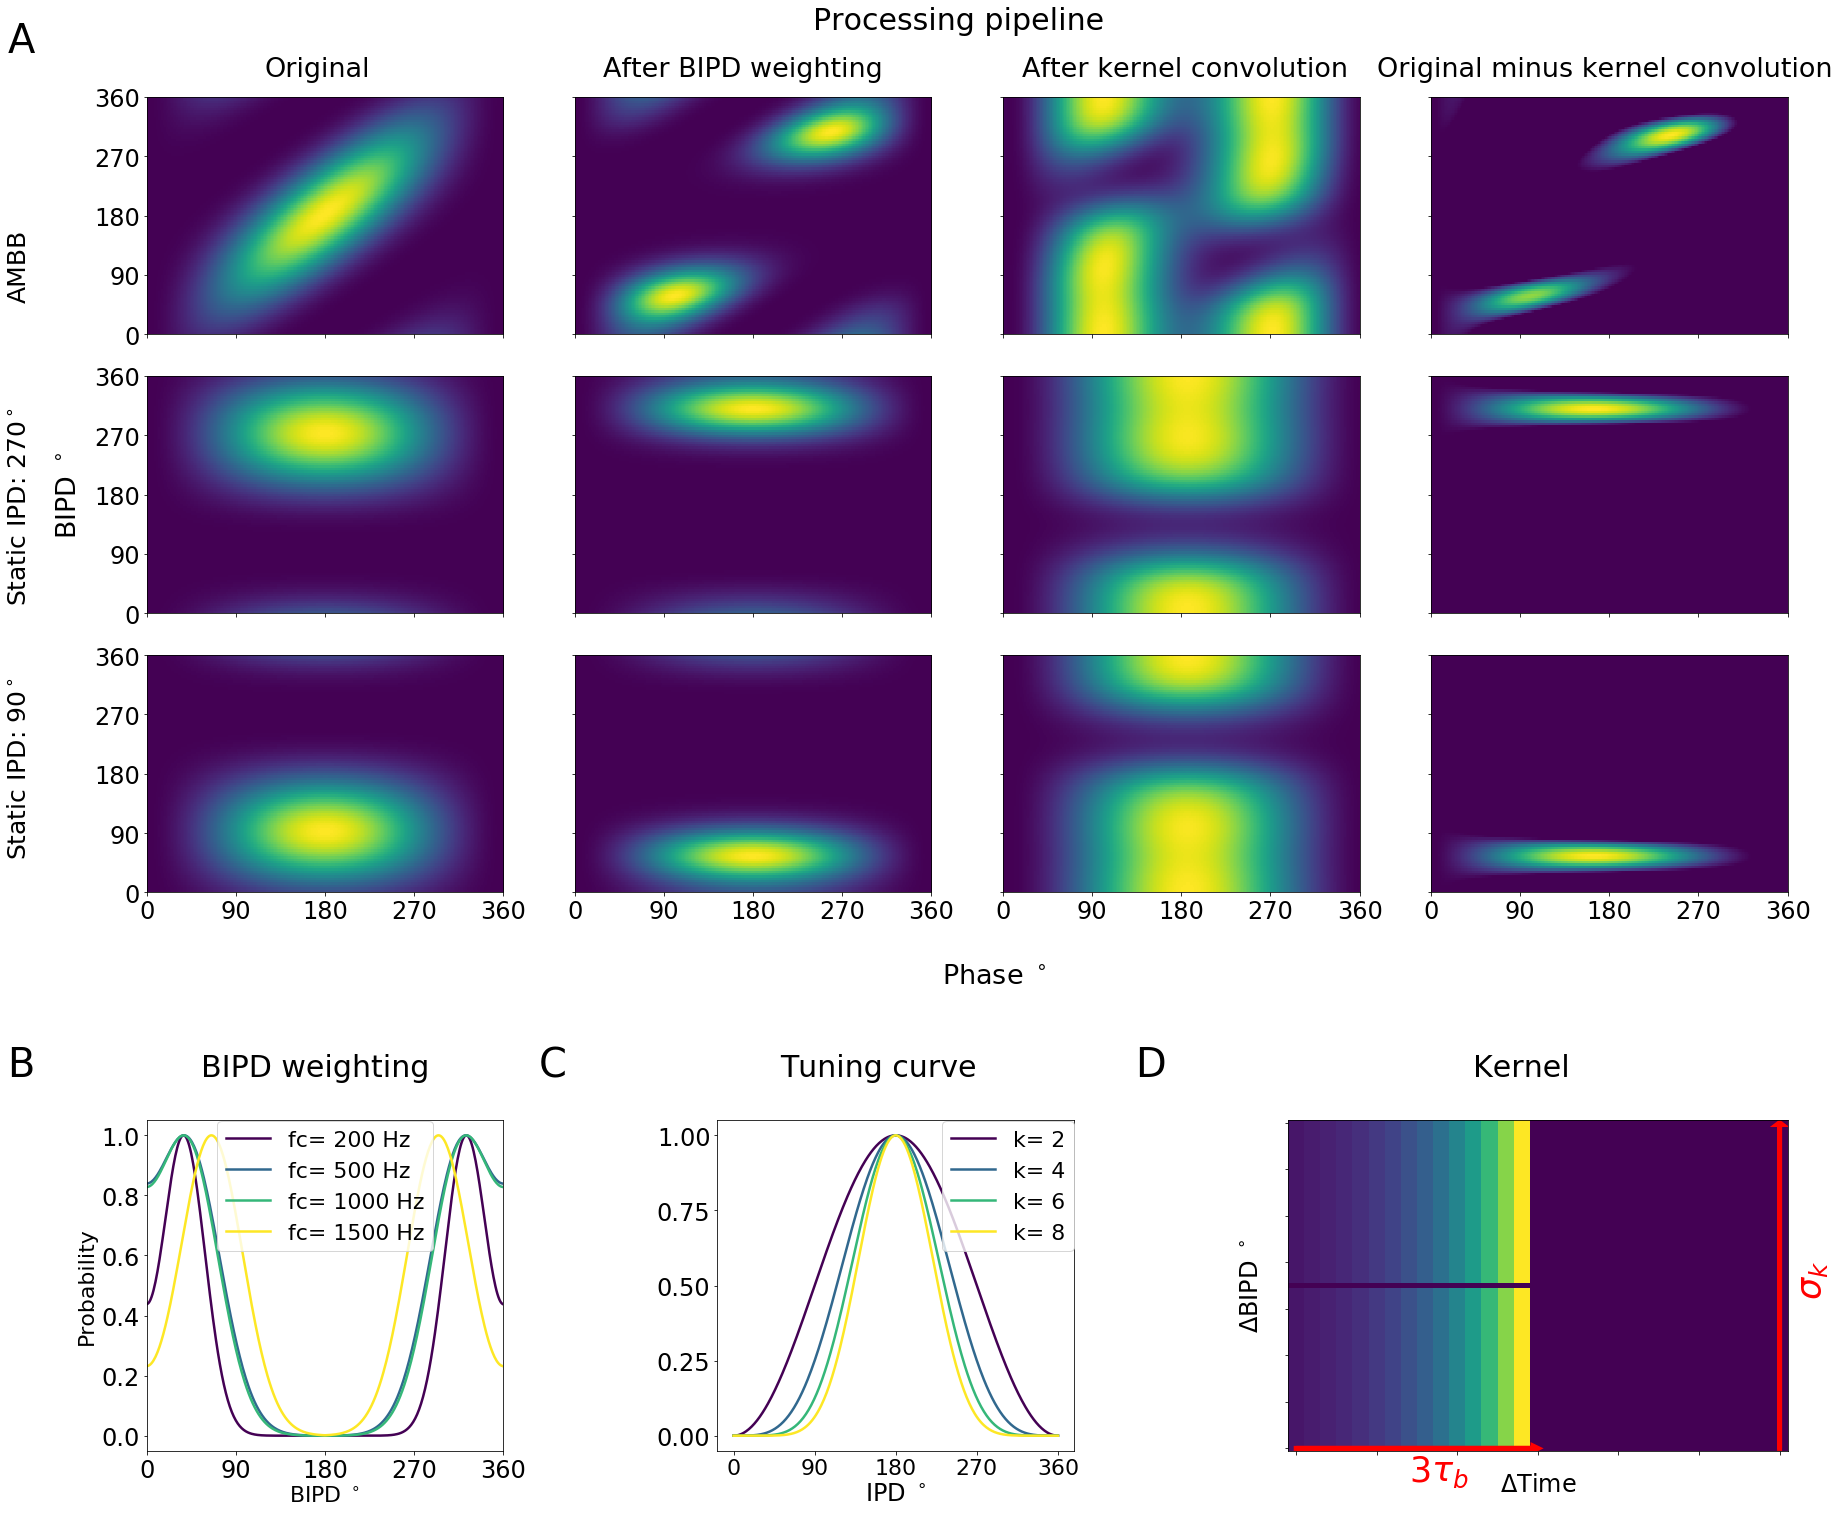

In [7]:
fig_proc_pop()